Andrew Pan

This work is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

# Computational Bayesian Statistics Report 2

In [2]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

# Bayes Theorem Problems

## Hospital Problem

From http://www.programminglogic.com/bayes-theorem-with-examples/

Suppose you are a hospital manager, and you are considering the use of a new method to diagnose a rare form of bowel syndrome. You know that only 0,1% of the population suffers from that disease. You also know that if a person has the disease, the test has 99% of chance of turning out positive. If the person doesn’t have the disease, the test has a 98% chance of turning negative.

How feasible is this diagnostics method? That is, given that a test turned out positive, what are the chances of the person really having the disease?

### Answer

To determine the probability of a positive result from the test actually indicating that the subject has bowel syndrome, we first need to determine our prior hypotheses.  In this problem, there are only two hypotheses: the patient either has this rare form of bowel syndrome, or doesn't.  The probability of having the disease is 0.1%, thus the probability of not having the disease is 99.9%.  We'll use a Pmf object to help solve this problem.

In [4]:
bowelSyndrome = Pmf()
bowelSyndrome['disease'] = .001
bowelSyndrome['no disease'] = .999

Next we need to update our priors with the likelihoods of the data.  The data in this problem is that the test is positive, so we need to multiply the values in our Pmf by the likelihoods of a positive test result for each hypotheses.  There is a 99% positive test result for patients with the disease, and a 98% negative test result for patients without, which equates to a 2% chance for healthy patients.  Multiplying our priors by these likelihoods yields our unnormalized posterior data.

In [5]:
bowelSyndrome['disease'] *= .99
bowelSyndrome['no disease'] *= .02

Now all we have to do is normalize our Pmf.

In [6]:
bowelSyndrome.Normalize()
bowelSyndrome.Print()

disease 0.047210300429184546
no disease 0.9527896995708154


So getting a positive result on the test means that a patient only actually has a 4.2% probability of actually having this rare bowel syndrome!

## FIFA Problem

In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. What is the probability that Germany had the better team? What is the probability that Germany would win a rematch?

For a prior distribution on the goal-scoring rate for each team, use a gamma distribution with parameter 1.3.

In [ ]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Goals per game')
pmf.Mean()

## GPS Problem

> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

## Lightbulb Prediction Problem

Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with lam=2 and k=1.5. If we install n=100 lightbulbs and come back one year later, what is the distribution of c, the number of lightbulbs that have burned out?

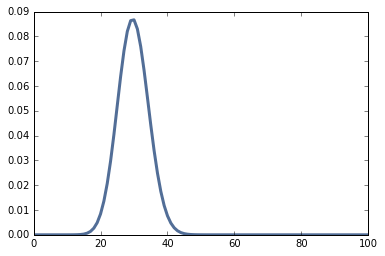

In [8]:
from thinkbayes2 import MakeBinomialPmf, EvalWeibullCdf
thinkplot.Pdf(MakeBinomialPmf(100, EvalWeibullCdf(1, 2, 1.5)))

Now suppose that lam and k are not known precisely, but we have a LightBulb object that represents the joint posterior distribution of the parameters after seeing some data. Compute the posterior predictive distribution for c, the number of bulbs burned out after one year.

# Original Bayes Theorem Problems

## Magical Dice Problem

One day on his way home from school, Billy found a shiny jewel on the side of the road.  Upon closer inspection, it turned out to be not a jewel, but a 100-sided die, and a magic one at that!  Each time Billy rolled the die, the values close to the value that landed face up became more likely to be rolled for all future rolls.  Billy managed to roll only prime numbers from 1 to 100, and rolled each prime exactly once.  Can you create a probability distribution to predict Billy's next roll?

### Answer

To solve this problem, we can begin by creating a class that extends Suite.  The only function from the Suite class that needs to be changed is the Likelihood function.  We need to make the Likelihood function increase the probability of values close to the rolled number, which in this case is the data argument.  Fortunately, the EvalNormalPdf function can be used to provide us with the necessary likelihoods since it returns the Pdf of the data from a normal distribution centered about its second argument.  Its third argument is used in scipy.stats.norm.pdf to scale the distribution, so in this case we want that scaling value to be the maximum difference between the data and hypothesis, 99.

In [37]:
from thinkbayes2 import EvalNormalPdf

class magicDie(Suite):
    def Likelihood(self, data, hypo):
        return EvalNormalPdf(data, hypo, 99)    

Now that we have our class, we just have to update it with all of the prime numbers that Billy rolled.

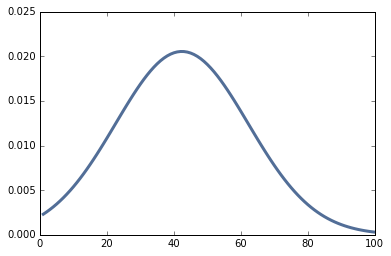

In [38]:
primes = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
mD = magicDie(range(1, 101))
for p in primes:
    mD.Update(p)
thinkplot.Pdf(mD)

And there's are probability distribution for Billy's next roll.  The distribution is shifted slightly to the left of the center of the graph because there are more prime numbers in the range of 1-50 than there are from 51-100, so Billy's next roll is slightly more likely to be less than 50 than it is to be above 50.